# Basic setup

## preprocessing

In [16]:
#!pip install datasets transformers scikit-learn

In [64]:
import json
import pandas as pd
from datasets import Dataset
import transformers

In [8]:
#using the other data sets (other stories) to try out the system
chunk_file = "../data/speckled-band-chunk-sentiment.json"
    
words_file = "../data/eng-spec.json"

In [10]:
with open(words_file, "r") as f:
    words_data = json.load(f)

with open(chunk_file, "r") as f:
    chunk_data = json.load(f)

In [13]:
def extract_sentence_sentiments(data1, data2):
    results = []
    for sentence in data1.get('sentences', []):
        sid = sentence['sid']
        sid_str = str(sid)
        words = [w['word'] for w in sentence.get('words', [])]
        text = sentence.get('text', '')
        sentiment_chunks = data2.get(sid_str)
        if not sentiment_chunks:
            continue
        overall_sentiment = sentiment_chunks[-1]['sentiment']
        results.append({
            'sid': sid,
            'text': text,
            'words': words,
            'sentiment': overall_sentiment
        })
    return results


In [27]:
# load and prepare data
data = extract_sentence_sentiments(words_data, chunk_data)
df = pd.DataFrame(data)
print(df.head())

     sid                                               text  \
0  10000                 The Adventure of the Speckled Band   
1  10001  On glancing over my notes of the seventy odd c...   
2  10002  Of all these varied cases, however, I cannot r...   
3  10003  The events in question occurred in the early d...   
4  10004  It is possible that I might have placed them u...   

                                               words  sentiment  
0          [The, Adventure, of, the, Speckled, Band]        2.0  
1  [On, glancing, over, my, notes, of, the, seven...        0.0  
2  [Of, all, these, varied, cases, ,, however, ,,...       -3.0  
3  [The, events, in, question, occurred, in, the,...        0.0  
4  [It, is, possible, that, I, might, have, place...      -32.0  


In [29]:
def label_sentiment(score):
    if score > 0:
        return "POSITIVE"
    elif score < -0:
        return "NEGATIVE"
    else:
        return "NEUTRAL"

label2id = {'NEGATIVE': 0, 'NEUTRAL': 1, 'POSITIVE': 2}
id2label = {v: k for k, v in label2id.items()}

# assign sentiment labels
df["sentiment_label"] = df["sentiment"].apply(label_sentiment)
df["label"] = df["sentiment_label"].map(label2id)

In [33]:
from sklearn.model_selection import StratifiedKFold
SEED = 23
# prepare folds
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)

In [38]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
def tokenize_function(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=128)

In [74]:
import evaluate
import numpy as np
accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")

def compute_metrics(p):
    logits, labels = p
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    precision = precision_metric.compute(predictions=predictions, references=labels, average="weighted")
    recall = recall_metric.compute(predictions=predictions, references=labels, average="weighted")
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="weighted")
    return {
        "accuracy": accuracy["accuracy"],
        "precision": precision["precision"],
        "recall": recall["recall"],
        "f1": f1["f1"],
    }

In [78]:
import csv

def save_sentence_level_predictions(texts, predictions, gold_labels, label_list, output_file_path):
    """
    Save sentence-level predictions with their texts and gold labels to a TSV file.

    Args:
        texts: List of sentence strings.
        predictions: List or array of predicted label IDs (one per sentence).
        gold_labels: List or array of true label IDs (one per sentence).
        label_list: List of string labels, where index corresponds to label ID.
        output_file_path: Path to save the TSV file.

    Returns:
        None
    """
    with open(output_file_path, 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f, delimiter='\t')
        writer.writerow(['sentence', 'prediction', 'gold_label'])

        for text, pred_id, gold_id in zip(texts, predictions, gold_labels):
            pred_label = label_list[pred_id]
            gold_label = label_list[gold_id]
            writer.writerow([text, pred_label, gold_label])

    print(f"Sentence-level results saved to {output_file_path}")


In [97]:
from datasets import Dataset
import torch
from transformers import AutoModelForSequenceClassification, TrainingArguments, AutoTokenizer, AutoModel, Trainer, DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
model_checkpoint = "bert-base-uncased"
model_name = model_checkpoint.split("/")[-1]
task = "sentiment_analysis"
batch_size = 16
metric = evaluate.load("seqeval")

all_state_dicts = []


best_model = None
best_tokenizer = None
best_score = -1
best_fold = -1


all_texts = []
all_preds = []
all_labels = []

for fold, (train_idx, val_idx) in enumerate(skf.split(df, df["label"])):
    print(f"\n==== Fold {fold+1} ====\n")
    train_df = df.iloc[train_idx]
    val_df = df.iloc[val_idx]

    # create HuggingFace datasets
    train_dataset = Dataset.from_pandas(train_df[["text", "label"]])
    val_dataset = Dataset.from_pandas(val_df[["text", "label"]])

    # tokenize
    train_dataset = train_dataset.map(tokenize_function, batched=True)
    val_dataset = val_dataset.map(tokenize_function, batched=True)

    # Load model
    model = AutoModelForSequenceClassification.from_pretrained(
        model_checkpoint,
        num_labels=3,
        id2label=id2label,
        label2id=label2id
    )

    args = TrainingArguments(
        output_dir=f"{model_name}-finetuned-{task}-fold{fold+1}",
        eval_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=3,
        weight_decay=0.01,
        seed=SEED,
        report_to=None,
        save_strategy="no"  # prevent saving too much if not needed
    )

    # Define Trainer
    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics
    )

    trainer.train()
    metrics = trainer.evaluate()
    print(metrics)

    # determining the best model, to save for later
    fold_score = metrics["eval_f1"]  # "eval_f1" is the metric

    if fold_score > best_score:
        best_score = fold_score
        best_fold = fold
        best_model = trainer.model
        best_tokenizer = tokenizer

    # determining the average model's performance
    state_dict = {k: v.cpu() for k, v in trainer.model.state_dict().items()}
    all_state_dicts.append(state_dict)

    # get predictions on the current fold's validation set
    raw_preds, gold_labels, _ = trainer.predict(val_dataset)
    predictions = np.argmax(raw_preds, axis=1)

    # recover the original texts (from val_df)
    texts = val_df["text"].tolist()

    # Collect predictions, labels, and texts for this fold
    all_texts.extend(val_df["text"].tolist())
    all_preds.extend(np.argmax(raw_preds, axis=1))
    all_labels.extend(gold_labels)



==== Fold 1 ====



Map: 100%|████████████████████████████| 60/60 [00:00<00:00, 11327.79 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/pk/23rj3vrj73x83046rkqn9g100000gn/T/ipykernel_2597/3814604330.py:59: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,1.006518,0.483333,0.433929,0.483333,0.363746
2,No log,0.912801,0.516667,0.641346,0.516667,0.446533
3,No log,0.884667,0.583333,0.684375,0.583333,0.540486


/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not

{'eval_loss': 0.8846668004989624, 'eval_accuracy': 0.5833333333333334, 'eval_precision': 0.684375, 'eval_recall': 0.5833333333333334, 'eval_f1': 0.5404858299595142, 'eval_runtime': 1.2145, 'eval_samples_per_second': 49.405, 'eval_steps_per_second': 3.294, 'epoch': 3.0}


/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



==== Fold 2 ====



Map: 100%|████████████████████████████| 60/60 [00:00<00:00, 13342.08 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/pk/23rj3vrj73x83046rkqn9g100000gn/T/ipykernel_2597/3814604330.py:59: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,1.002948,0.466667,0.359483,0.466667,0.315882
2,No log,0.949309,0.500000,0.488333,0.500000,0.402241
3,No log,0.907484,0.533333,0.559375,0.533333,0.471429


/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not

{'eval_loss': 0.9074837565422058, 'eval_accuracy': 0.5333333333333333, 'eval_precision': 0.559375, 'eval_recall': 0.5333333333333333, 'eval_f1': 0.4714285714285714, 'eval_runtime': 1.2194, 'eval_samples_per_second': 49.203, 'eval_steps_per_second': 3.28, 'epoch': 3.0}


/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



==== Fold 3 ====



Map: 100%|████████████████████████████| 60/60 [00:00<00:00, 13244.47 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/pk/23rj3vrj73x83046rkqn9g100000gn/T/ipykernel_2597/3814604330.py:59: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,1.021349,0.483333,0.521469,0.483333,0.331962
2,No log,0.943442,0.566667,0.594444,0.566667,0.509612
3,No log,0.915515,0.600000,0.611318,0.600000,0.562323


/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not

{'eval_loss': 0.9155145883560181, 'eval_accuracy': 0.6, 'eval_precision': 0.6113178294573643, 'eval_recall': 0.6, 'eval_f1': 0.562322708178898, 'eval_runtime': 1.2252, 'eval_samples_per_second': 48.973, 'eval_steps_per_second': 3.265, 'epoch': 3.0}


/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



==== Fold 4 ====



Map: 100%|████████████████████████████| 60/60 [00:00<00:00, 13265.42 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/pk/23rj3vrj73x83046rkqn9g100000gn/T/ipykernel_2597/3814604330.py:59: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,1.021891,0.500000,0.371242,0.500000,0.396062
2,No log,0.990957,0.516667,0.508250,0.516667,0.463894
3,No log,0.976885,0.516667,0.508250,0.516667,0.463894


/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not

{'eval_loss': 0.976885199546814, 'eval_accuracy': 0.5166666666666667, 'eval_precision': 0.5082496413199425, 'eval_recall': 0.5166666666666667, 'eval_f1': 0.4638940648723257, 'eval_runtime': 1.2506, 'eval_samples_per_second': 47.976, 'eval_steps_per_second': 3.198, 'epoch': 3.0}


/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



==== Fold 5 ====



Map: 100%|████████████████████████████| 60/60 [00:00<00:00, 13312.43 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/pk/23rj3vrj73x83046rkqn9g100000gn/T/ipykernel_2597/3814604330.py:59: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.982696,0.516667,0.425408,0.516667,0.422558
2,No log,0.924339,0.566667,0.577132,0.566667,0.533675
3,No log,0.911949,0.600000,0.599573,0.600000,0.579440


/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.9119489192962646, 'eval_accuracy': 0.6, 'eval_precision': 0.5995726495726497, 'eval_recall': 0.6, 'eval_f1': 0.5794400431858304, 'eval_runtime': 1.2748, 'eval_samples_per_second': 47.068, 'eval_steps_per_second': 3.138, 'epoch': 3.0}


/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



==== Fold 6 ====



Map: 100%|████████████████████████████| 60/60 [00:00<00:00, 12922.78 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/pk/23rj3vrj73x83046rkqn9g100000gn/T/ipykernel_2597/3814604330.py:59: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,1.038242,0.466667,0.445238,0.466667,0.386742
2,No log,0.980207,0.466667,0.420035,0.466667,0.401037
3,No log,0.961187,0.500000,0.452650,0.500000,0.453379


/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.9611865878105164, 'eval_accuracy': 0.5, 'eval_precision': 0.4526495726495727, 'eval_recall': 0.5, 'eval_f1': 0.45337860780984723, 'eval_runtime': 1.2903, 'eval_samples_per_second': 46.501, 'eval_steps_per_second': 3.1, 'epoch': 3.0}


/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



==== Fold 7 ====



Map: 100%|████████████████████████████| 60/60 [00:00<00:00, 13116.76 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/pk/23rj3vrj73x83046rkqn9g100000gn/T/ipykernel_2597/3814604330.py:59: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.988828,0.433333,0.209195,0.433333,0.282171
2,No log,0.890705,0.533333,0.529861,0.533333,0.481324
3,No log,0.899353,0.600000,0.640152,0.600000,0.561852


/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.8993526101112366, 'eval_accuracy': 0.6, 'eval_precision': 0.6401515151515151, 'eval_recall': 0.6, 'eval_f1': 0.5618518518518518, 'eval_runtime': 1.2935, 'eval_samples_per_second': 46.385, 'eval_steps_per_second': 3.092, 'epoch': 3.0}


/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



==== Fold 8 ====



Map: 100%|████████████████████████████| 60/60 [00:00<00:00, 10727.58 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/pk/23rj3vrj73x83046rkqn9g100000gn/T/ipykernel_2597/3814604330.py:59: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,1.018397,0.450000,0.213559,0.450000,0.289655
2,No log,0.943636,0.583333,0.588485,0.583333,0.542416
3,No log,0.921907,0.633333,0.638568,0.633333,0.614357


/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not

{'eval_loss': 0.9219070672988892, 'eval_accuracy': 0.6333333333333333, 'eval_precision': 0.6385683760683761, 'eval_recall': 0.6333333333333333, 'eval_f1': 0.6143570938411391, 'eval_runtime': 1.2816, 'eval_samples_per_second': 46.818, 'eval_steps_per_second': 3.121, 'epoch': 3.0}


/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



==== Fold 9 ====



Map: 100%|█████████████████████████████| 60/60 [00:00<00:00, 9136.92 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/pk/23rj3vrj73x83046rkqn9g100000gn/T/ipykernel_2597/3814604330.py:59: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,1.039591,0.483333,0.471469,0.483333,0.331633
2,No log,1.022469,0.516667,0.601631,0.516667,0.465951
3,No log,0.998521,0.466667,0.566667,0.466667,0.438542


/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not

{'eval_loss': 0.9985208511352539, 'eval_accuracy': 0.4666666666666667, 'eval_precision': 0.5666666666666667, 'eval_recall': 0.4666666666666667, 'eval_f1': 0.43854166666666666, 'eval_runtime': 1.3014, 'eval_samples_per_second': 46.106, 'eval_steps_per_second': 3.074, 'epoch': 3.0}


/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)



==== Fold 10 ====



Map: 100%|████████████████████████████| 59/59 [00:00<00:00, 10405.51 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/pk/23rj3vrj73x83046rkqn9g100000gn/T/ipykernel_2597/3814604330.py:59: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,1.019822,0.491525,0.372881,0.491525,0.370056
2,No log,0.951185,0.559322,0.573344,0.559322,0.536082
3,No log,0.922841,0.576271,0.586859,0.576271,0.556295


/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not

{'eval_loss': 0.9228413105010986, 'eval_accuracy': 0.576271186440678, 'eval_precision': 0.5868594682154004, 'eval_recall': 0.576271186440678, 'eval_f1': 0.5562953995157385, 'eval_runtime': 1.3254, 'eval_samples_per_second': 44.515, 'eval_steps_per_second': 3.018, 'epoch': 3.0}


/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [99]:
#determining the best model
if best_model:
    best_model.save_pretrained("best_sent_level_model")
    best_tokenizer.save_pretrained("best_sent_level_model")
    print(f"Best model saved from fold {best_fold+1} with score {best_score:.4f}")


Best model saved from fold 8 with score 0.6144


In [101]:
# determining an average model
avg_state_dict = all_state_dicts[0]

for key in avg_state_dict:
    for i in range(1, len(all_state_dicts)):
        avg_state_dict[key] += all_state_dicts[i][key]
    avg_state_dict[key] /= len(all_state_dicts)

# Load into a new model and save
avg_model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=3)
avg_model.load_state_dict(avg_state_dict)
avg_model.save_pretrained("avg_sent_level_model")
tokenizer.save_pretrained("avg_sent_level_model")
print("Averaged model saved.")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Averaged model saved.


In [88]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def evaluate_sentence_predictions(predictions, labels, label_list):
    """
    Evaluate sentence-level predictions and print metrics.

    Args:
        predictions: numpy array or list of predicted label IDs
        labels: numpy array or list of true label IDs
        label_list: list of label strings, e.g. ["NEGATIVE", "NEUTRAL", "POSITIVE"]
    """
    # Convert IDs to label strings
    pred_labels = [label_list[p] for p in predictions]
    true_labels = [label_list[l] for l in labels]

    accuracy = accuracy_score(true_labels, pred_labels)
    report = classification_report(true_labels, pred_labels, target_names=label_list, digits=4)

    cm = confusion_matrix(true_labels, pred_labels, labels=label_list)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_list)

    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:\n", report)
    disp.plot(cmap=plt.cm.Purples, xticks_rotation='vertical')
    plt.title("Confusion Matrix")
    plt.show()


Sentence-level results saved to all_folds_sentence_predictions.tsv
Accuracy: 0.5643
Classification Report:
               precision    recall  f1-score   support

    NEGATIVE     0.5542    0.8484    0.6705       277
     NEUTRAL     0.6140    0.2414    0.3465       145
    POSITIVE     0.5763    0.3842    0.4610       177

    accuracy                         0.5643       599
   macro avg     0.5815    0.4913    0.4927       599
weighted avg     0.5752    0.5643    0.5302       599



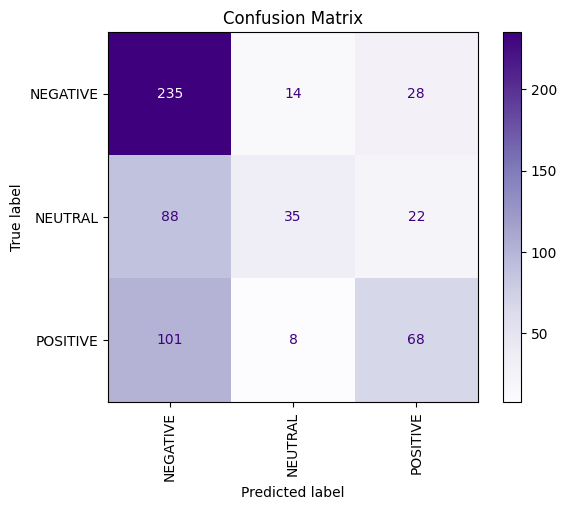

In [90]:
label_list = ["NEGATIVE", "NEUTRAL", "POSITIVE"]
# save all folds' predictions together
save_sentence_level_predictions(
    texts=all_texts,
    predictions=all_preds,
    gold_labels=all_labels,
    label_list=label_list,
    output_file_path="all_folds_sentence_predictions.tsv"
)

# evaluate the combined results
evaluate_sentence_predictions(all_preds, all_labels, label_list)
